# Import packages

In [2]:
import sys
sys.path.append("..")
from liver_microsome_prediction.utils import *

# Load data

In [50]:
train_data = pd.read_csv(PATH.train)
targets = ['MLM', 'HLM']
train_data

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.01,50.68,3.26,400.50,5,2,8,3.26,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.27,50.59,2.17,301.41,2,1,2,2.17,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.59,80.89,1.59,297.36,5,0,3,1.58,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC5)CC4)c3C)nn2)cc1,5.71,2.00,4.77,494.65,6,0,5,3.48,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.27,99.99,2.33,268.31,3,0,1,2.34,42.43
...,...,...,...,...,...,...,...,...,...,...,...
3493,TRAIN_3493,Cn1nc(CNC(=O)Cn2nc(C(F)(F)F)c3c2CCC3)c(Cl)c1Cl,1.56,3.08,3.41,396.19,3,1,5,3.41,64.74
3494,TRAIN_3494,CCn1[nH]cc/c1=N\C(=O)c1nn(-c2ccccc2)c(=O)c2ccccc12,35.56,47.63,1.91,359.38,4,1,3,1.84,77.37
3495,TRAIN_3495,CCOC(=O)CCCc1nc2cc(N)ccc2n1C,56.15,1.79,1.94,261.32,3,1,6,2.12,70.14
3496,TRAIN_3496,Nc1cc(C(=O)OCCC2CCOC2=O)cnc1Cl,0.03,2.77,0.99,284.70,5,1,5,0.99,91.51


In [51]:
train_data.loc[train_data.AlogP.isna(), 'AlogP'] = train_data.AlogP.mean()

In [52]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3498 non-null   object 
 1   SMILES                      3498 non-null   object 
 2   MLM                         3498 non-null   float64
 3   HLM                         3498 non-null   float64
 4   AlogP                       3498 non-null   float64
 5   Molecular_Weight            3498 non-null   float64
 6   Num_H_Acceptors             3498 non-null   int64  
 7   Num_H_Donors                3498 non-null   int64  
 8   Num_RotatableBonds          3498 non-null   int64  
 9   LogD                        3498 non-null   float64
 10  Molecular_PolarSurfaceArea  3498 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 300.7+ KB


In [53]:
from sklearn.preprocessing import StandardScaler

scaler   = StandardScaler()
features = train_data.columns.drop(['id', 'SMILES'] + targets)
train_data[features] = scaler.fit_transform(train_data[features])

In [68]:
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

models       = {target: [] for target in targets}
train_scores = []
val_scores   = []

for train_idxs, val_idxs in tqdm(KFold(n_splits=10, random_state=SEED, shuffle=True).split(train_data)):
    X_train, ys_train = train_data.loc[train_idxs][features], train_data.loc[train_idxs][targets]
    X_val,   ys_val   = train_data.loc[val_idxs][features],   train_data.loc[val_idxs][targets]
    
    train_score, val_score = 0, 0
    for target in targets:
        y_train, y_val = ys_train[target], ys_val[target]
        model = RandomForestRegressor(random_state=SEED).fit(X_train, y_train)
        train_score += mean_squared_error(y_train, model.predict(X_train), squared=False)
        val_score   += mean_squared_error(y_val,   model.predict(X_val), squared=False)
        models[target].append(model)
    train_scores.append(train_score/2)
    val_scores.append(val_score/2)

print(np.mean(train_scores), train_scores)
print(np.mean(val_scores), val_scores)

10it [00:20,  2.06s/it]

12.496353971984794 [12.421650010826543, 12.456915889013112, 12.512576501792044, 12.472455413027106, 12.531047178527539, 12.440100406459322, 12.51175939135662, 12.578060664816665, 12.496024605692046, 12.542949658336944]
33.01720341136294 [34.16627171192236, 33.97627620318549, 33.10756665154956, 34.62924125736169, 32.40636108198477, 33.22483534677101, 31.87830492432722, 31.938741866119997, 31.745395635173466, 33.099039435233884]


# Submission

In [74]:
test_data  = pd.read_csv(PATH.test)
submission = pd.read_csv(PATH.sample)

In [83]:
test_data.loc[test_data.AlogP.isna(), 'AlogP'] = train_data.AlogP.mean()
test_data[features] = scaler.transform(test_data[features])

In [93]:
for target in models:
    submission[target] = np.array([model.predict(test_data[features]) for model in models[target]]).mean(axis=0)

In [95]:
submission.head()

,id,MLM,HLM
0,TEST_000,30.54,46.06
1,TEST_001,67.58,79.45
2,TEST_002,27.99,41.04
3,TEST_003,44.55,75.19
4,TEST_004,54.93,77.82


In [106]:
output_path = join(PATH.out, '1_example_random_forest.csv')
submission.to_csv(output_path, index=False)

In [107]:
from dacon_submit_api import dacon_submit_api

dacon_submit_api.post_submission_file(
    output_path,
    '236127',
    'alchemine',
    '1_example_random_forest'
)

{'isSubmitted': True, 'detail': 'Success'}


<Response [200]>

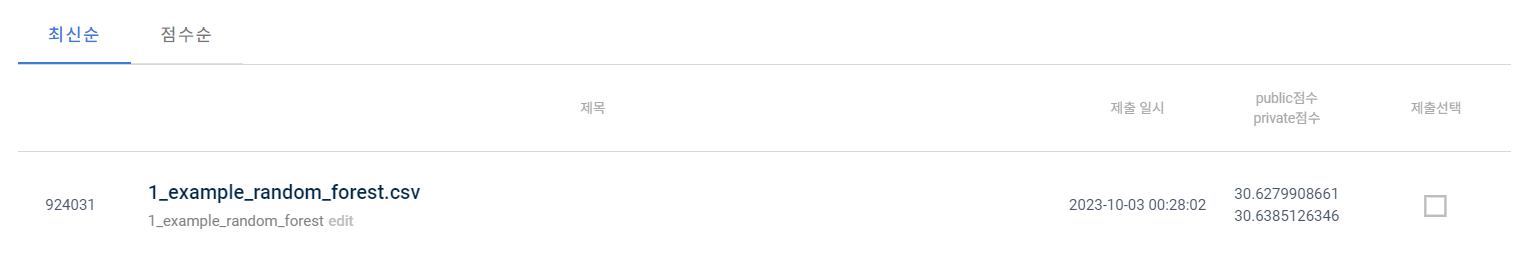